In [93]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from matplotlib.pyplot import subplots

from ISLP import load_data

## The below is not needed, simply the authors removing complexity 
## for those uncomfortable with the methods used by statsmodels or scikit-learn
from ISLP.models import (ModelSpec as MS, summarize , poly)

In [59]:
# ISLP.load_data returns a pd.DataFrame
boston = load_data("Boston")
list(boston.columns)

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'lstat',
 'medv']

In [49]:
test = [1]*506

In [56]:
X = pd.DataFrame({'intercept': np.ones(boston.shape[0]), 'lstat': boston['lstat']})

Why add `intercept` key with an array of `1`'s:  According to the documentation for `statsmodels.regression.linear_model.OLS` found [here](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS):

exog: array_like
A nobs x k array where nobs is the number of observations and k is the number of regressors. An intercept is not included by default and should be added by the user. See statsmodels.tools.add_constant.

If it is not `1`'s it will not properly calculate the coefficient. 

You can also use the following to add a constant:  `sm.add_constant` returns a `pd.DataFrame`

If you don't do sm.add_constant then statsmodels algorithms assume that b=0 in y = mx + b, and it'll fit the model using b=0 instead of calculating what b is supposed to be based on your data.

In [64]:
X = sm.add_constant(boston[['lstat']])

In [87]:
X.head()

,const,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [25]:
y = boston['medv']

In [62]:
model = sm.OLS(y,X)
results = model.fit()

In [86]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 28 Aug 2023   Prob (F-statistic):           5.08e-88
Time:                        20:18:52   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,34.5538,0.563,61.415,0.000,33.448,35.659
lstat,-0.9500,0.039,-24.528,0.000,-1.026,-0.874


### Make predictions

In [88]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
new_df = sm.add_constant(new_df)
new_df

,const,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [90]:
predictions = results.get_prediction(new_df)
predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [91]:
# Confidence interval
predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [94]:
# Prediction interval
predictions.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

In [97]:
def abline(ax, b, m, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

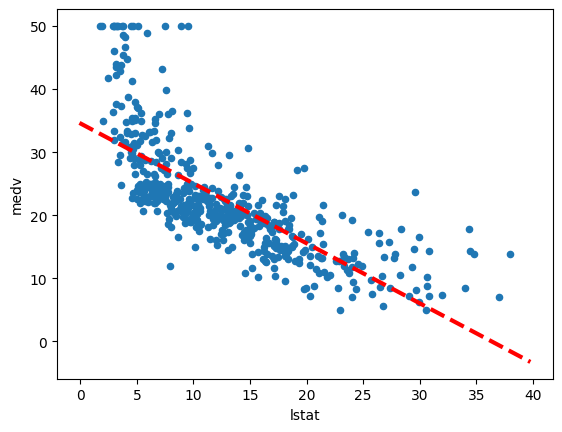

In [98]:
ax = boston.plot.scatter('lstat', 'medv')
abline(ax,
    results.params[0],
    results.params[1],
    'r--',
    linewidth=3)


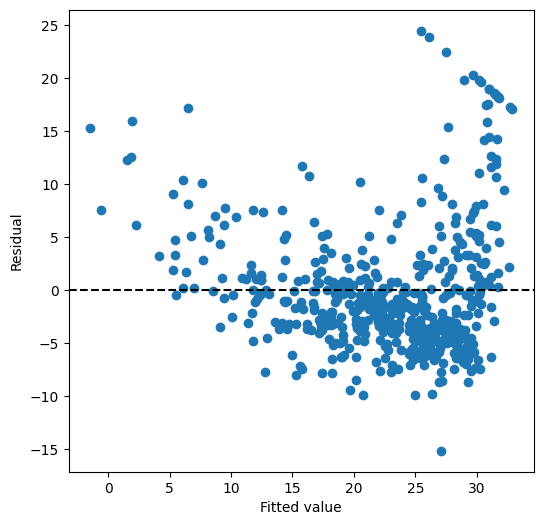

In [107]:
ax = subplots(figsize=(6,6))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

374

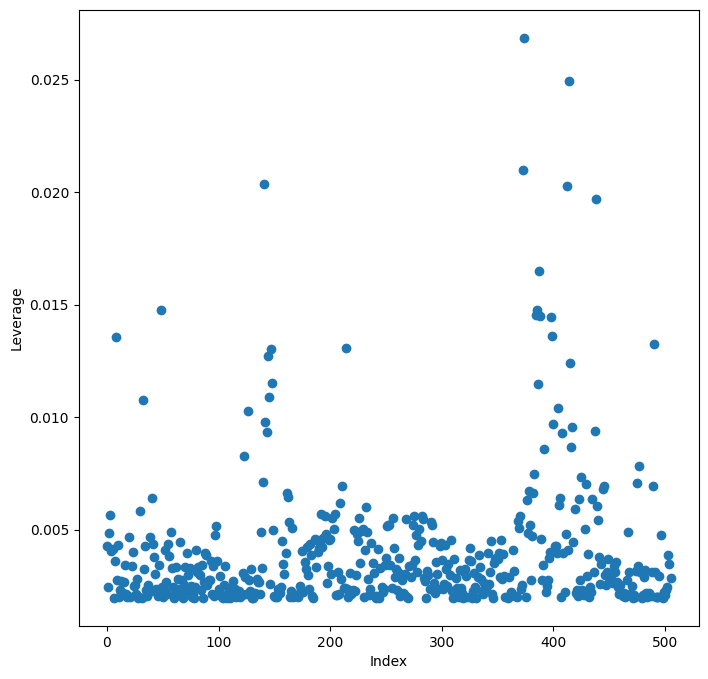

In [109]:
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# returns the value with the most leverage
np.argmax(infl.hat_matrix_diag)

In [118]:
## Observation with the most leverage
boston[374:375]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
374,18.4982,0.0,18.1,0,0.668,4.138,100.0,1.137,24,666,20.2,37.97,13.8


### Multiple linear regression

In [121]:
X = sm.add_constant(boston[['lstat','age']])
model_1 = sm.OLS(y, X)
results_1 = model_1.fit()
results_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,33.2228,0.731,45.458,0.000,31.787,34.659
lstat,-1.0321,0.048,-21.416,0.000,-1.127,-0.937
age,0.0345,0.012,2.826,0.005,0.011,0.059


#### Use all the variables

In [127]:
X = sm.add_constant(boston[boston.columns.drop('medv')])
model_2 = sm.OLS(y, X)
results_2 = model_2.fit()
results_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,41.6173,4.936,8.431,0.000,31.919,51.316
crim,-0.1214,0.033,-3.678,0.000,-0.186,-0.057
zn,0.0470,0.014,3.384,0.001,0.020,0.074
indus,0.0135,0.062,0.217,0.829,-0.109,0.136
chas,2.8400,0.870,3.264,0.001,1.131,4.549
nox,-18.7580,3.851,-4.870,0.000,-26.325,-11.191
rm,3.6581,0.420,8.705,0.000,2.832,4.484
age,0.0036,0.013,0.271,0.787,-0.023,0.030
dis,-1.4908,0.202,-7.394,0.000,-1.887,-1.095
rad,0.2894,0.067,4.325,0.000,0.158,0.421


In [128]:
results.rsquared

0.5441462975864799

#### Making an interaction term

$$ \hat{y}_i = \hat{\beta_0} + \hat{\beta_1}x_{i,1} + \hat{\beta_2}x_{i,2} + \hat{\beta_3}x_{i,1}*x_{i,2}$$

Unlike in R, you need to add the column to your dataframe.

In [129]:
boston['lstat:age']=boston.lstat*boston.age

In [136]:
X = sm.add_constant(boston[['lstat','age','lstat:age']])

In [138]:
X.head()

,const,lstat,age,lstat:age
0,1.0,4.98,65.2,324.696
1,1.0,9.14,78.9,721.146
2,1.0,4.03,61.1,246.233
3,1.0,2.94,45.8,134.652
4,1.0,5.33,54.2,288.886


In [139]:
model_3 = sm.OLS(y, X)
results_3 = model_3.fit()
results_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,36.0885,1.470,24.553,0.000,33.201,38.976
lstat,-1.3921,0.167,-8.313,0.000,-1.721,-1.063
age,-0.0007,0.020,-0.036,0.971,-0.040,0.038
lstat:age,0.0042,0.002,2.244,0.025,0.001,0.008


#### Fit a model with a square term

In [141]:
boston['lstat^2']=np.square(boston.lstat)

In [147]:
X = sm.add_constant(boston[['lstat','lstat^2','age']])
model_4 = sm.OLS(y, X)
results_4 = model_4.fit()
results_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,41.2885,0.873,47.284,0.000,39.573,43.004
lstat,-2.6883,0.131,-20.502,0.000,-2.946,-2.431
lstat^2,0.0495,0.004,13.315,0.000,0.042,0.057
age,0.0703,0.011,6.471,0.000,0.049,0.092


In [149]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(boston)

In [150]:
X.head()

,intercept,"poly(lstat, degree=2)[0]","poly(lstat, degree=2)[1]",age
0,1.0,-0.047815,0.038955,65.2
1,1.0,-0.021892,-0.010782,78.9
2,1.0,-0.053734,0.053604,61.1
3,1.0,-0.060527,0.071920,45.8
4,1.0,-0.045634,0.033866,54.2
